# 1.0 update library pandas

### we should update pandas to avoid any prblem



---



In [ ]:
# Upgrade pandas to use dataframe.explode() function. 
!pip install --upgrade pandas==0.25.0

<h1>2.0 import dataset <h1>

---



In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0

In [ ]:
import os
# to get file 
print(os.getcwd())
os.listdir(path=".")


/content


['.config',
 '.ipynb_checkpoints',
 'tmdb-movies.csv',
 'Investigate_a_Dataset.ipynb',
 'Investigate_a_Dataset.html',
 'drive',
 'sample_data']

In [ ]:
os.chdir("Database_TMDb_movie_data")


FileNotFoundError: ignored

<h1>3.0 import libraries </h1>
<h3> we will need pandas and matplotlib library 


---





In [178]:
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

# 4.0 import dataset


---



In [179]:
df = pd.read_csv("tmdb-movies.csv")
df.head(10)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,keywords,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,monster|dna|tyrannosaurus rex|velociraptor|island,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,future|chase|post-apocalyptic|dystopia|australia,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,based on novel|revolution|dystopia|sequel|dyst...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08
3,140607,tt2488496,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,android|spaceship|jedi|space opera|3d,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/15,5292,7.5,2015,1.839999e+08,1.902723e+09
4,168259,tt2820852,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,car race|speed|revenge|suspense|car,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/15,2947,7.3,2015,1.747999e+08,1.385749e+09
5,281957,tt1663202,9.110700,135000000,532950503,The Revenant,Leonardo DiCaprio|Tom Hardy|Will Poulter|Domhn...,http://www.foxmovies.com/movies/the-revenant,Alejandro GonzÃ¡lez IÃ±Ã¡rritu,"(n. One who has returned, as if from the dead.)",father-son relationship|rape|based on novel|mo...,"In the 1820s, a frontiersman, Hugh Glass, sets...",156,Western|Drama|Adventure|Thriller,Regency Enterprises|Appian Way|CatchPlay|Anony...,12/25/15,3929,7.2,2015,1.241999e+08,4.903142e+08
6,87101,tt1340138,8.654359,155000000,440603537,Terminator Genisys,Arnold Schwarzenegger|Jason Clarke|Emilia Clar...,http://www.terminatormovie.com/,Alan Taylor,Reset the future,saving the world|artificial intelligence|cybor...,"The year is 2029. John Connor, leader of the r...",125,Science Fiction|Action|Thriller|Adventure,Paramount Pictures|Skydance Productions,6/23/15,2598,5.8,2015,1.425999e+08,4.053551e+08
7,286217,tt3659388,7.667400,108000000,595380321,The Martian,Matt Damon|Jessica Chastain|Kristen Wiig|Jeff ...,http://www.foxmovies.com/movies/the-martian,Ridley Scott,Bring Him Home,based on novel|mars|nasa|isolation|botanist,"During a manned mission to Mars, Astronaut Mar...",141,Drama|Adventure|Science Fiction,Twentieth Century Fox Film Corporation|Scott F...,9/30/15,4572,7.6,2015,9.935996e+07,5.477497e+08
8,211672,tt2293640,7.404165,74000000,1156730962,Minions,Sandra Bullock|Jon Hamm|Michael Keaton|Allison...,http://www.minionsmovie.com/,Kyle Balda|Pierre Coffin,"Before Gru, they had a history of bad bosses",assistant|aftercreditsstinger|duringcreditssti...,"Minions Stuart, Kevin and Bob are recruited by...",91,Family|Animation|Adventure|Comedy,Universal Pictures|Illumination Entertainment

## 4.1 get data types of all columns

In [180]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

# <h1>6  Data cleaning </h1>


<h2>5.1 first Delete all the columns we don't need this column ("id" and "imdb" and "tagline","overview","keywords","homepage" ,"budget","revenue)</h2>

In [181]:
df.drop(["id","imdb_id"],axis=1,inplace = True) # 

In [182]:
df.drop(["tagline","overview","keywords","homepage"],axis=1,inplace = True) # id and imdb id this we will not need it

In [183]:
# for budget we will use budget_adj as the same with  revenue
df.drop(["budget","revenue"],axis=1,inplace = True) # id and imdb id this we will not need it

In [184]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 13 columns):
popularity              10866 non-null float64
original_title          10866 non-null object
cast                    10790 non-null object
director                10822 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              10866 non-null float64
revenue_adj             10866 non-null float64
dtypes: float64(4), int64(3), object(6)
memory usage: 1.1+ MB


## 5.2 get rows that have null values and delete it 


In [185]:
print(f"before delete nan value {df.shape[0]}  and after delete nan value {df.shape[0]-df.isnull().any(axis=1).sum()}")
df.dropna(inplace=True)

before delete nan value 10866  and after delete nan value 9773


In [186]:
df.shape

(9773, 13)

# 6 data wrangle 
## 5.1 calculate the profits

In [187]:
df["profits"]=df["revenue_adj"]-df[("budget_adj")]


## 6.2 set the column of release date (release data is string column we want to convert it ot datatime column

In [188]:
df["release_date"] = pd.to_datetime(df["release_date"])
y= df["release_date"].dt.year
m= df["release_date"].dt.month
d=df["release_date"].dt.day

In [189]:
y[y>2015]=y[y > 2015]-100
del df["release_date"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: modifications to a property of a datetimelike object are not supported and are discarded. Change values on the original.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:9116: SettingWithCopyWarning: modifications to a property of a datetimelike object are not supported and are discarded. Change values on the original.
  self._update_inplace(new_data)


In [190]:
df["release_date"] =  y.apply(str) + "-"+m.apply(str)+"-"+d.apply(str) 
df["release_date"]=pd.to_datetime(df["release_date"])

In [191]:
df["release_date"]

0       2015-06-09
1       2015-05-13
2       2015-03-18
3       2015-12-15
4       2015-04-01
           ...    
10861   1966-06-15
10862   1966-12-21
10863   1966-01-01
10864   1966-11-02
10865   1966-11-15
Name: release_date, Length: 9773, dtype: datetime64[ns]

<h2>6.3 rename column ('budget_adj' to 'budget) and ('revenue_adj' to 'revenue')</h2>


In [192]:
df.rename(columns = {'budget_adj':'budget', 'revenue_adj':'revenue'}, inplace=True)
# rename budget and revenue

In [193]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9773 entries, 0 to 10865
Data columns (total 14 columns):
popularity              9773 non-null float64
original_title          9773 non-null object
cast                    9773 non-null object
director                9773 non-null object
runtime                 9773 non-null int64
genres                  9773 non-null object
production_companies    9773 non-null object
vote_count              9773 non-null int64
vote_average            9773 non-null float64
release_year            9773 non-null int64
budget                  9773 non-null float64
revenue                 9773 non-null float64
profits                 9773 non-null float64
release_date            9773 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(3), object(5)
memory usage: 1.1+ MB


In [194]:
df['genres'] = df['genres'].str.split('|')


In [195]:
df['cast'] = df['cast'].str.split('|')

In [196]:
df["production_companies"]=df["production_companies"].str.split("|")

In [197]:
df = pd.concat([df], keys=['data'], names=['data type'], axis=1)

## 6.4 get every cast or company or genres in column
## this well help you much specifically in machine learning 

### 6.4.1 get Cast (True or False)

In [198]:

get_all_cast=[]
for x in df.iterrows():
    for k in x[1][2]: # cast
        if k not in get_all_cast:
            get_all_cast.append(k)

        


In [199]:
x= df[("data","cast")].str.join("  ||| ")
for y in get_all_cast:
    df[("Cast",y)]=x.str.contains(y)

### 6.4.2 get genres (True , False)

In [200]:

get_all_genres=[]
for x in df.iterrows():
    for k in x[1][5]: 
        if k not in get_all_genres:
            get_all_genres.append(k)
x= df[("data","genres")].str.join("  ||| ")
for y in get_all_genres:
    df[("Genres",y)]=x.str.contains(y)

In [201]:
df["Genres"]

,Action,Adventure,Science Fiction,Thriller,Fantasy,Crime,Western,Drama,Family,Animation,Comedy,Mystery,Romance,War,History,Music,Horror,Documentary,TV Movie,Foreign
0,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,True,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,True,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5,False,True,False,True,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False
6,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
7,False,True,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
8,False,True,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False


### 6.4.3 get production companies	

In [202]:
get_pc=[]
for x in df.iterrows():
    for k in x[1][6]: 
        if k not in get_pc:
            get_pc.append(k)

In [203]:
x= df[("data","production_companies")].str.join("  ||| ")

In [204]:
for y in get_pc:
    try:
        df[("Production_companies",str(y))]=x.str.contains(str(y))
    except:
        print("this error ",y)

/usr/local/lib/python3.7/dist-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


this error  Underground Films\


In [205]:
x= df[("data","production_companies")].str.join("  ||| ")
x=x.str.contains("Underground Films")
df[("Production_companies","Underground Films")]=x

In [206]:
df["Production_companies"]

,Universal Studios,Amblin Entertainment,Legendary Pictures,Fuji Television Network,Dentsu,Village Roadshow Pictures,Kennedy Miller Productions,Summit Entertainment,Mandeville Films,Red Wagon Entertainment,NeoReel,Lucasfilm,Truenorth Productions,Bad Robot,Universal Pictures,Original Film,Media Rights Capital,One Race Films,Regency Enterprises,Appian Way,CatchPlay,Anonymous Content,New Regency Pictures,Paramount Pictures,Skydance Productions,Twentieth Century Fox Film Corporation,Scott Free Productions,Mid Atlantic Films,International Traders,TSG Entertainment,Illumination Entertainment,Walt Disney Pictures,Pixar Animation Studios,Walt Disney Studios Motion Pictures,Columbia Pictures,Danjaq,B24,Dune Entertainment,Anarchos Productions,Warner Bros.,...,Innovisions,F.O.D. Productions,Watership Productions,Glen A. Larson Productions,TAT Communications Company,Filmways Australasian,Australian International Film Corp. (AIFC),Coatesgold,Manitou Productions Ltd.,KISS Productions,Jayne Productions Inc,FM Productions,Last Waltz Inc.,Victorian Film,Dugong Films,The Cat in the Hat Productions,Anglo Enterprises,Vineyard Film Ltd.,Chenault Productions,Thalia AG,Bridge Films,Carlo Ponti Production,Highland Films,William Dozier Productions,Greenlawn Productions,Phalanx-Jaelem,C.B. Films S.A.,Proteus Films,Julian Blaustein Productions Ltd.,Planet Film Productions,Protelco,High Road,Eden Productions Inc.,Embassy Pictures,John Frankenheimer Productions Inc.,Bruce Brown Films,Douglas & Lewis Productions,Benedict Pictures Corp.,Norm-Iris,Underground Films
0,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,Fals

### now we did not need cast ,genres ,production_companies columns we will delete it





In [207]:
del df[("data","cast")]
del df[("data","genres")]
del df[("data","production_companies")]

#  7. data explore 




# 7.1  top 20 actors Participation in the moives




[Text(0, 0.5, 'number of appearance'),
 Text(0.5, 0, 'name of actors'),
 Text(0.5, 1.0, 'top 20 actors Participation in the moives')]

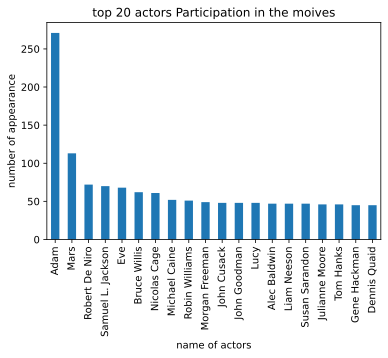

In [208]:
ax=df["Cast"].sum().sort_values(ascending=False).head(20).plot.bar()
ax.set(title="top 20 actors Participation in the moives",ylabel="number of appearance",xlabel="name of actors")

##7.2 top 20 revenue

[Text(0, 0.5, 'Revenue'),
 Text(0.5, 0, 'name of moive'),
 Text(0.5, 1.0, 'Top 20 revenue')]

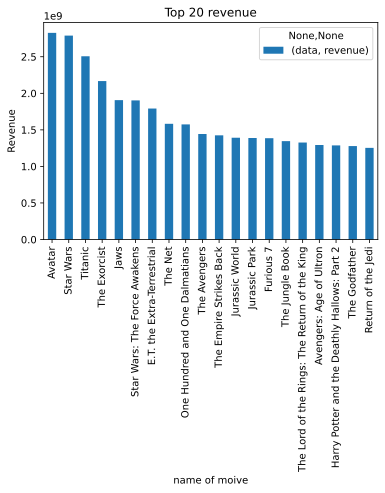

In [209]:

top_20=df.loc[df[("data","revenue")].sort_values(ascending=False).head(20).index].plot.bar(x=("data","original_title"),y=("data","revenue"))
top_20.set(title="Top 20 revenue",xlabel="name of moive",ylabel="Revenue")


## 7.2 top 20 budget

[Text(0, 0.5, 'budget'),
 Text(0.5, 0, 'name of moive'),
 Text(0.5, 1.0, 'Top 20 revenue')]

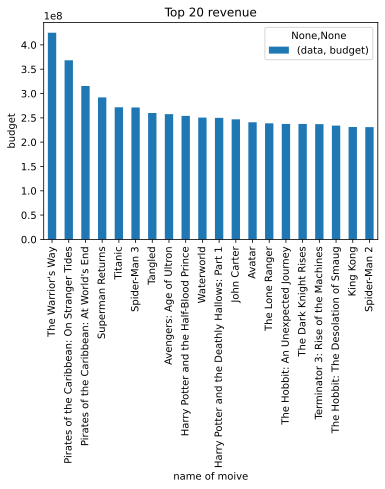

In [210]:

top_20=df.loc[df[("data","budget")].sort_values(ascending=False).head(20).index].plot.bar(x=("data","original_title"),y=("data","budget"))
top_20.set(title="Top 20 revenue",xlabel="name of moive",ylabel="budget")


##7.3 top 20 popularity

[Text(0, 0.5, 'popularity'),
 Text(0.5, 0, 'name of moive'),
 Text(0.5, 1.0, 'Top 20 revenue')]

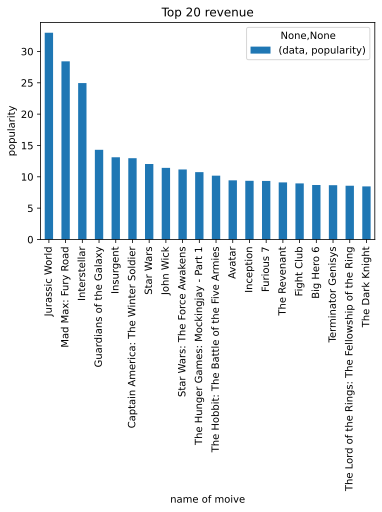

In [211]:

top_20=df.loc[df[("data","popularity")].sort_values(ascending=False).head(20).index].plot.bar(x=("data","original_title"),y=("data","popularity"))
top_20.set(title="Top 20 revenue",xlabel="name of moive",ylabel="popularity")


## 7.4 top 20 vote count

[Text(0, 0.5, 'vote_count'),
 Text(0.5, 0, 'name of moive'),
 Text(0.5, 1.0, 'Top 20 revenue')]

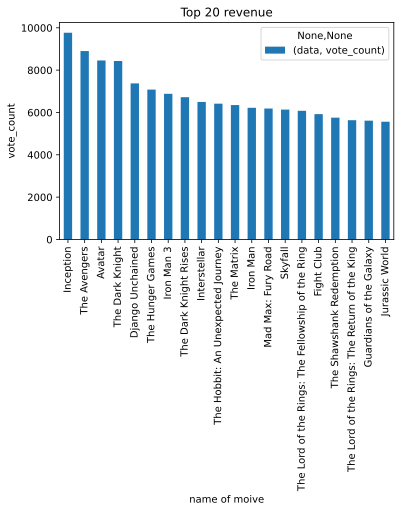

In [212]:

top_20=df.loc[df[("data","vote_count")].sort_values(ascending=False).head(20).index].plot.bar(x=("data","original_title"),y=("data","vote_count"))
top_20.set(title="Top 20 revenue",xlabel="name of moive",ylabel="vote_count")

##7.5 top 20 vote average


[Text(0, 0.5, 'vote_average'),
 Text(0.5, 0, 'name of moive'),
 Text(0.5, 1.0, 'Top 20 revenue')]

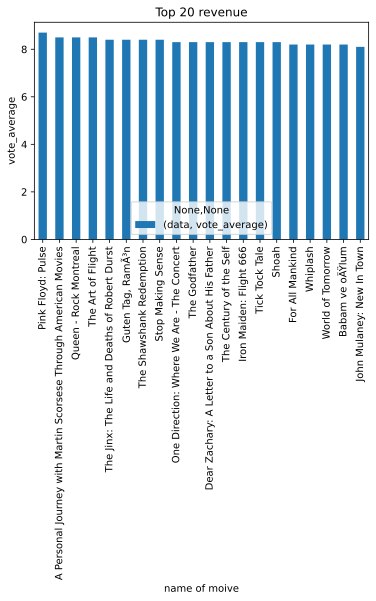

In [213]:
top_20=df.loc[df[("data","vote_average")].sort_values(ascending=False).head(20).index]
ax =top_20.plot.bar(x=("data","original_title"),y=("data","vote_average"))
ax.set(title="Top 20 revenue",xlabel="name of moive",ylabel="vote_average")

## 7.6 top 20 director Participate in moives


[Text(0.5, 1.0, 'top 20 director Participate in moives')]

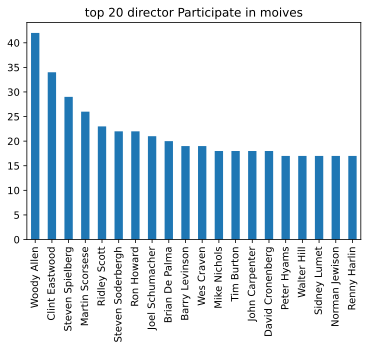

In [214]:
 
top_20=df[("data","director")].value_counts().sort_values(ascending=False).head(20).plot.bar()
top_20.set(title="top 20 director Participate in moives")

## 7.7 top  20 geners  in moives


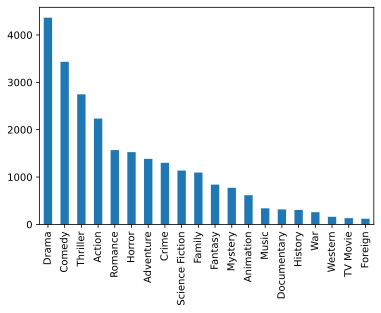

In [215]:
top_20=df["Genres"].sum().sort_values(ascending=False).head(20)
top_20.plot.bar()

## 7.8 top  20 company  in moives


[Text(0, 0.5, 'number of moives'), Text(0.5, 0, 'name of company')]

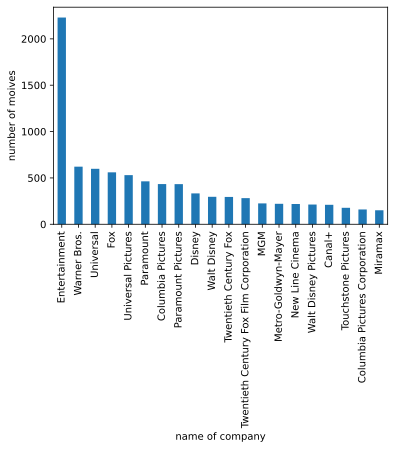

In [216]:
top_20=df["Production_companies"].sum().sort_values(ascending=False).head(20)
ax=top_20.plot.bar()
ax.set(xlabel="name of company",ylabel="number of moives")

## 7.9 top  20 moives get profits


[Text(0, 0.5, 'profits'),
 Text(0.5, 0, 'name of moive'),
 Text(0.5, 1.0, 'Top 20 profits')]

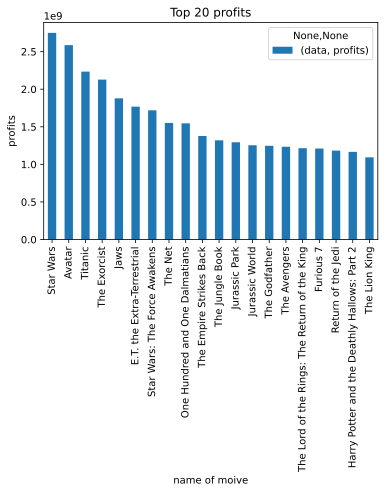

In [217]:
top_20=df.loc[df[("data","profits")].sort_values(ascending=False).head(20).index]
ax =top_20.plot.bar(x=("data","original_title"),y=("data","profits"))
ax.set(title="Top 20 profits",xlabel="name of moive",ylabel="profits")

## 7.10 revenue with profits with budjet


[Text(0, 0.5, 'profits'),
 Text(0.5, 0, 'name of moive'),
 Text(0.5, 1.0, 'Top 20 profits')]

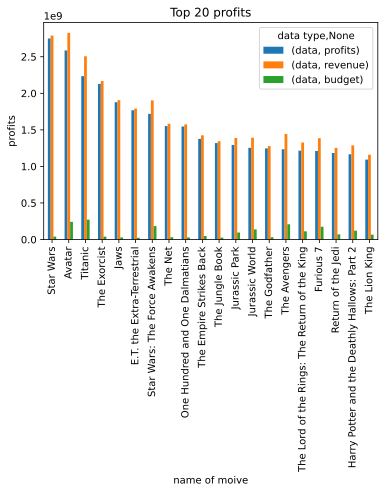

In [218]:
# revenue with profits with budjet
top_20=df.loc[df[("data","profits")].sort_values(ascending=False).head(20).index]
ax =top_20.plot.bar(x=("data","original_title"),y=[("data","profits"),("data","revenue"),("data","budget")],stacked=False)
ax.set(title="Top 20 profits",xlabel="name of moive",ylabel="profits")

## 7.11 runtime peroperties

In [219]:

df[("data",'runtime')].describe()


count    9773.000000
mean      102.925509
std        27.876224
min         0.000000
25%        90.000000
50%       100.000000
75%       112.000000
max       877.000000
Name: (data, runtime), dtype: float64

## 7.12 popularity with runtime releation




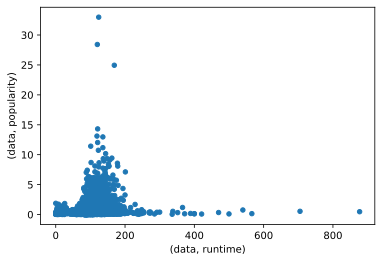

In [220]:
df.plot(y=("data","popularity"),x=("data","runtime") ,kind="scatter")

## 7.13 profits with  budget relation


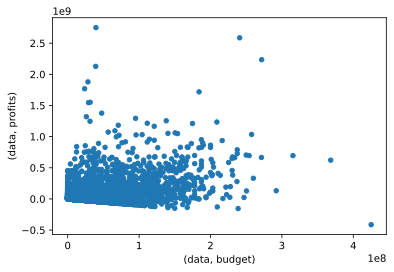

In [221]:
df.plot(y=("data","profits"),x=("data","budget"), kind="scatter" )

##7.14 producation per year

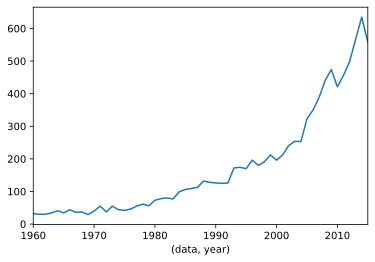

In [222]:

df[("data","year")]=df[("data","release_date")].dt.year
x=df.groupby(by=[("data","year")]).count()[("data","original_title")]
x.plot()

## 7.15 the top 20 company make max 

[Text(0, 0.5, 'profits'),
 Text(0.5, 0, 'company name'),
 Text(0.5, 1.0, 'total profits')]

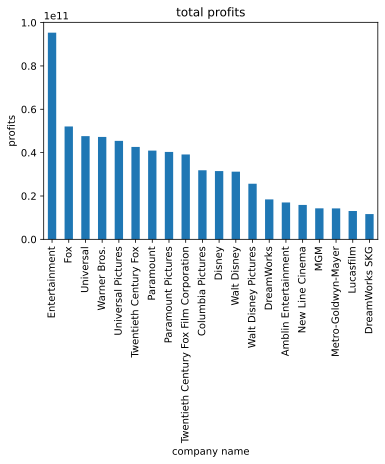

In [223]:
comp_profits =pd.Series()
for x in df["Production_companies"].columns:
  comp_profits[x]=df[df[("Production_companies",x)] > 0][("data","profits")].sum()
x=comp_profits.sort_values(ascending=False).head(20).plot.bar()
x.set(title="total profits",xlabel="company name",ylabel="profits")

# Conclusion
## this project depend on 4 main step 
  1. import library and data set
  2. clean data from any null values and Delete columns that cannot be used
  3. wrangle data , This is done by reformatting release data column and reconfiguring profits column and if any company genres or comapny or actor Participated in moive must be True to make that easy i use multiidnex 2 level 
  4. explore data By setting questions and answering them
